In [1]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import numpy as np

path = '/home/gholland/projects/bias/data/hddm_fits'

# SELECT MASK
masks = ['STh_L', 'STh_R', 'STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']
models = ['drift_bold', 'drift_errors_bold', 'start_point_bold', 'all_bold']

if 'PBS_ARRAYID' in os.environ:
    mask_idx = int(os.environ['PBS_ARRAYID']) / len(models)
    model_idx = int(os.environ['PBS_ARRAYID']) % len(models)
else:
    mask_idx = 0
    model_idx = 0

mask = masks[mask_idx]
model = models[model_idx]

def get_model(model, mask):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

    mask_stim = '{}_stim'.format(mask)
    mask_cue = '{}_cue'.format(mask)

    # Prepare data
    data = df[['cue_validity', 'rt', 'correct', 'difficulty', 'subj_idx', 'cue', mask_stim, mask_cue]]
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    if model == 'drift_bold':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}'.format(mask_stim), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'drift_errors_bold':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{} + {}:correct'.format(mask_stim, mask_stim), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'start_point_bold':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}'.format(mask_cue), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'all_bold':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}'.format(mask_cue), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{} + {}:correct'.format(mask_stim, mask_stim), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])
        
        
    if model == 'start_point_directional_bold':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{} + cue:(cue_coding:{})'.format(mask_cue, mask_cue), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])        
        
        
        

    return hddm_model

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python2.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [81]:
get_model('start_point_directional_bold', 'STh_L')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_cue', 'z_cue[T.neutral]:cue_coding:STh_L_cue', 'z_cue[T.right]:cue_coding:STh_L_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']


In [2]:
import glob
import re

In [34]:
results = []

for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:

    model = 'start_point_bold'

    hddm_model = get_model(model, mask)

    reg = re.compile('.*/traces_{model}_{mask}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{mask}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_models = [hddm_model.load_db(fn, db='pickle') for fn in fns]
    
    traces = pandas.concat([m.get_traces() for m in hddm_models], ignore_index=True)
    
    results.append(pandas.DataFrame({'threshold ~ bold':traces['z_cue_coding:{mask}_cue'.format(**locals())],
                                     'mask':mask,
                                     'hemisphere':mask[4],
                                      'sector':mask[6]}))
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_B_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_B_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']


In [43]:
df = pandas.concat(results)
df['hemisphere'] = df['mask'].apply(lambda x: x[6])
df['sector'] = df['mask'].apply(lambda x: x[4])

In [44]:
sns.set_context('poster')
sns.set_style('whitegrid')

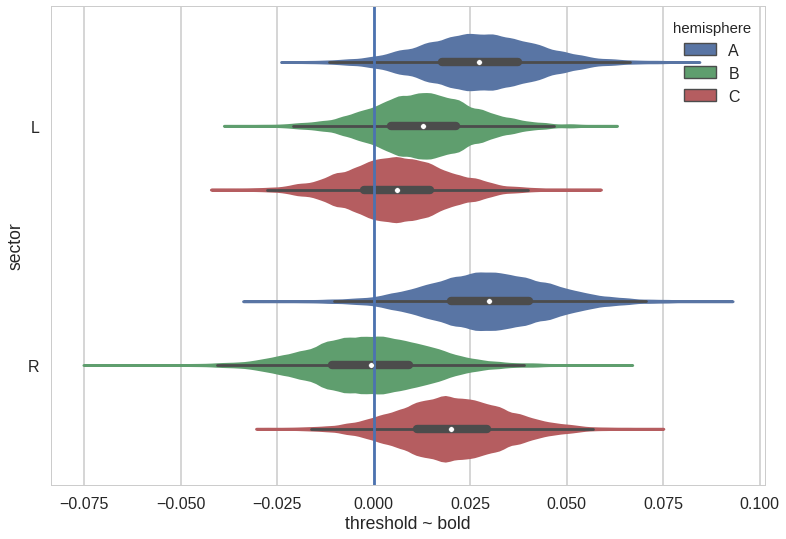

In [45]:
sns.violinplot('threshold ~ bold', 'sector', 'hemisphere', df)
plt.axvline(0,)

# drift bold

In [65]:
results = []

for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:

    model = 'drift_bold'

    hddm_model = get_model(model, mask)

    reg = re.compile('.*/traces_{model}_{mask}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{mask}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_models = [hddm_model.load_db(fn, db='pickle') for fn in fns]
    
    traces = pandas.concat([m.get_traces() for m in hddm_models], ignore_index=True)
    
    results.append(pandas.DataFrame({'drift ~ bold (easy)':traces['v_{}_stim'.format(mask)],
                                     'drift ~ bold (hard)':traces['v_{}_stim'.format(mask)] + traces['v_C(difficulty)[T.hard]:{}_stim'.format(mask)] ,
                                     'mask':mask,
                                     'hemisphere':mask[4],
                                      'sector':mask[6]}))
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C

In [66]:
df = pandas.concat(results)
df['hemisphere'] = df['mask'].apply(lambda x: x[4])
df['sector'] = df['mask'].apply(lambda x: x[6])

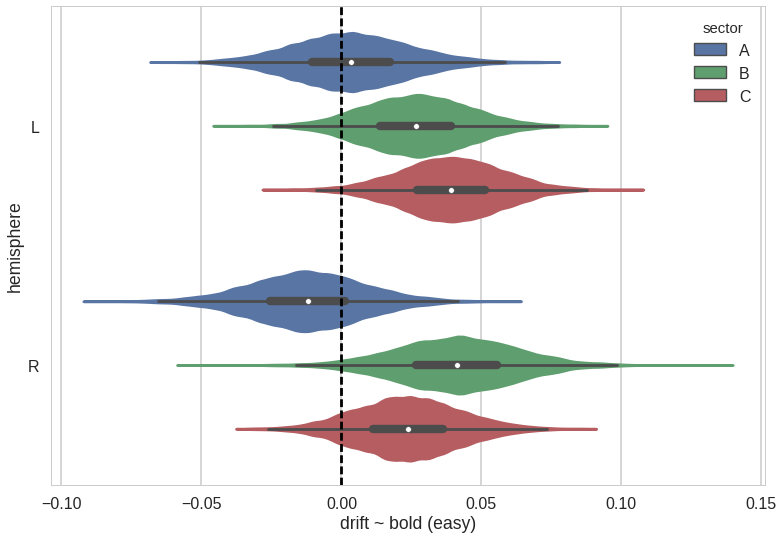

In [72]:
sns.violinplot('drift ~ bold (easy)', 'hemisphere', 'sector', df)
plt.axvline(0, c='k', ls='--')

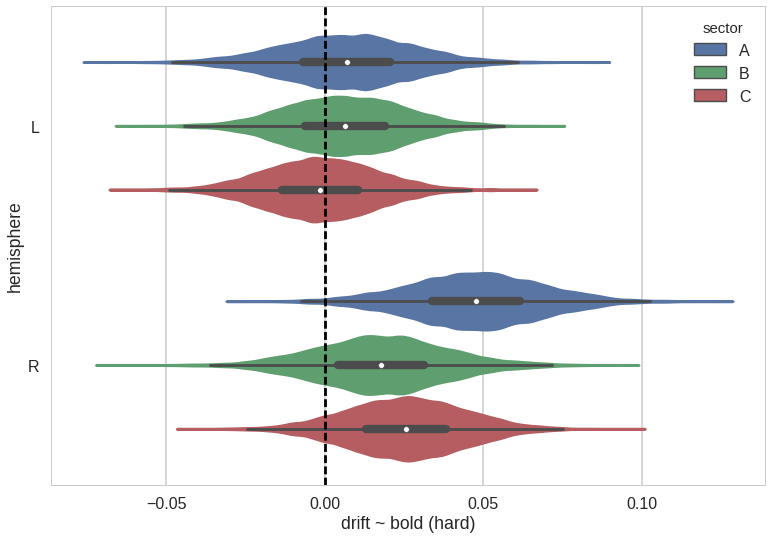

In [73]:
sns.violinplot('drift ~ bold (hard)', 'hemisphere', 'sector', df)
plt.axvline(0, c='k', ls='--')

In [71]:
df.groupby(['mask', 'sector']).apply(lambda x: (x > 0).mean())

,,drift ~ bold (easy),drift ~ bold (hard),hemisphere,mask,sector
mask,sector,,,,,
STh_L_A,A,0.563556,0.627667,1.0,1.0,1.0
STh_L_B,B,0.922556,0.628222,1.0,1.0,1.0
STh_L_C,C,0.983556,0.467778,1.0,1.0,1.0
STh_R_A,A,0.270778,0.988889,1.0,1.0,1.0
STh_R_B,B,0.973111,0.809222,1.0,1.0,1.0
STh_R_C,C,0.899778,0.915222,1.0,1.0,1.0


# Drift, bold, errors

In [61]:
results = []

for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:

    model = 'drift_errors_bold'

    hddm_model = get_model(model, mask)

    reg = re.compile('.*/traces_{model}_{mask}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{mask}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_models = [hddm_model.load_db(fn, db='pickle') for fn in fns]
    
    traces = pandas.concat([m.get_traces() for m in hddm_models], ignore_index=True)
    
    results.append(pandas.DataFrame({
                                    'drift ~ bold (easy, correct)':traces['v_{}_stim'].format(mask) + traces['v_{}_stim:correct'.format(mask)]
                                    'drift ~ bold (hard, correct)':traces['v_{}_stim'.format(mask)] + traces['v_{}_stim:correct'.format(mask)] + traces['v_C(difficulty)[T.hard]:{}_stim'.format(mask)] 
                                    'drift ~ bold (easy, error)':traces['v_{}_stim'.format(mask)]
                                    'drift ~ bold (hard, error)':traces['v_{}_stim'.format(mask)] + traces['v_C(difficulty)[T.hard]:{}_stim'.format(mask)] 
                                     'mask':mask,
                                     'hemisphere':mask[4],
                                      'sector':mask[6]}))
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim']


KeyError: 'v_STh_L_A_stim:correct'

In [53]:
df = pandas.concat(results)
df['hemisphere'] = df['mask'].apply(lambda x: x[4])
df['sector'] = df['mask'].apply(lambda x: x[6])

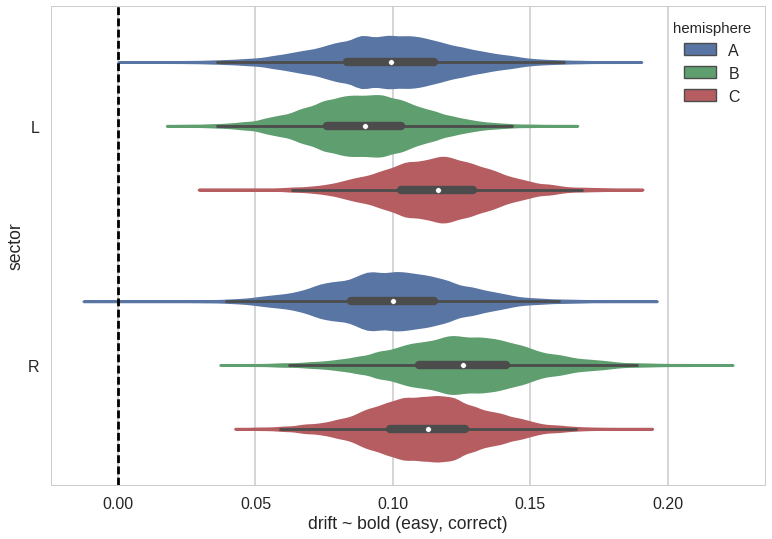

In [56]:
sns.violinplot('drift ~ bold (easy, correct)', 'sector', 'hemisphere', df)
plt.axvline(0, c='k', ls='--')

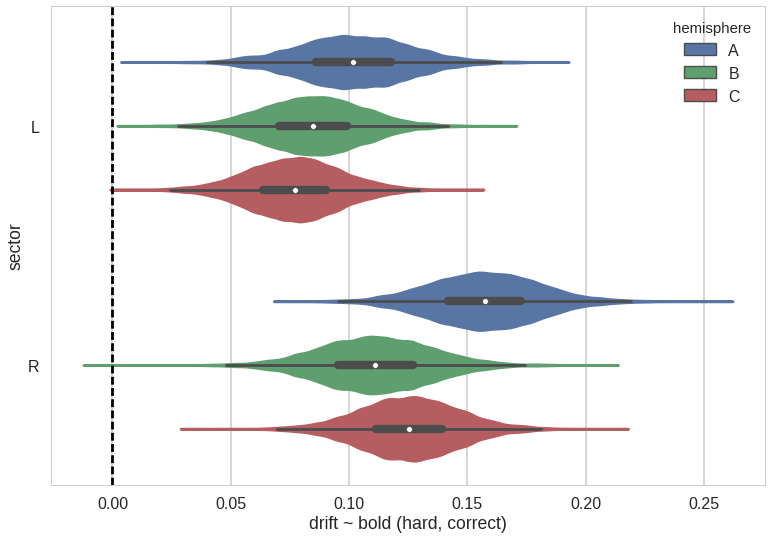

In [57]:
sns.violinplot('drift ~ bold (hard, correct)', 'sector', 'hemisphere', df)
plt.axvline(0, c='k', ls='--')

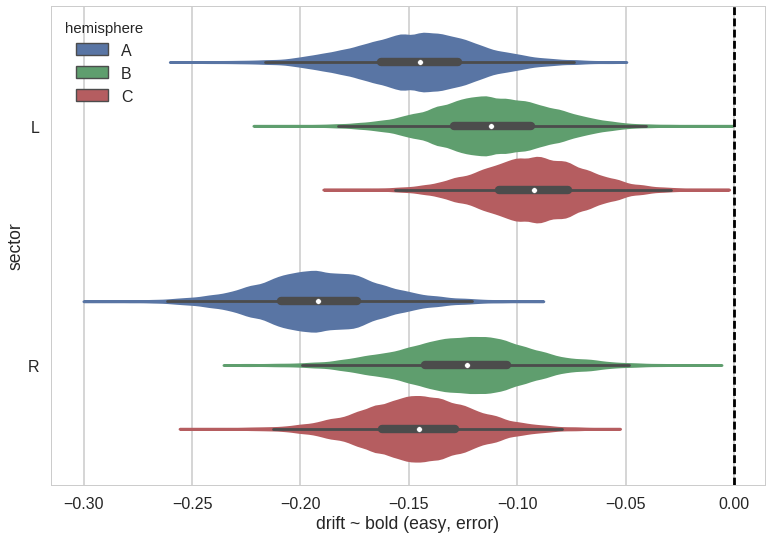

In [59]:
sns.violinplot('drift ~ bold (easy, error)', 'sector', 'hemisphere', df)
plt.axvline(0, c='k', ls='--')

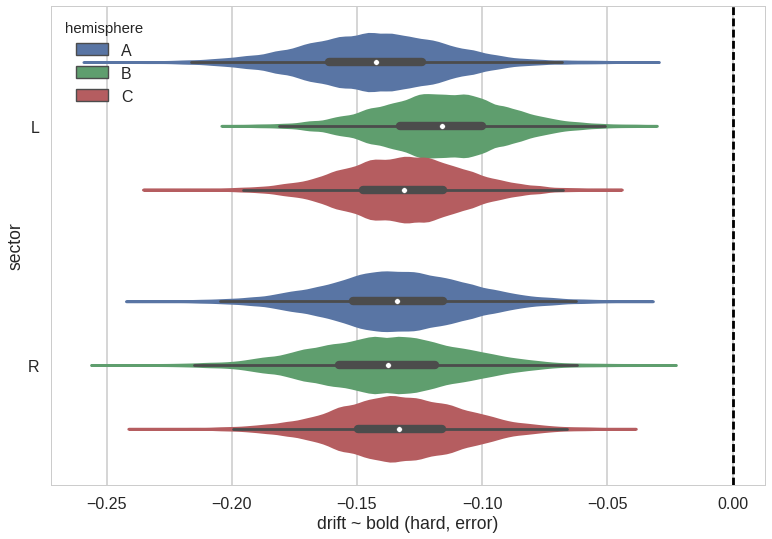

In [58]:
sns.violinplot('drift ~ bold (hard, error)', 'sector', 'hemisphere', df)
plt.axvline(0, c='k', ls='--')

# Super models

In [4]:
import pandas
import hddm

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python2.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [5]:
def get_model(model, hemisphere):
    
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

    # Prepare data
    data = df
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    if model == 'drift_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim + C(difficulty)*{}_stim'.format('STh_{}_A'.format(hemisphere),
                                                                                                                 'STh_{}_B'.format(hemisphere),
                                                                                                                 'STh_{}_C'.format(hemisphere),),
                 'link_func': lambda x: x}

        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'drift_errors_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])


    if model == 'start_point_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'], p_outlier=0.05)


    if model == 'all_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])
        
        
    if model == 'all_super_drift_bias':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + '
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])
        
    if model == 'final_super_model_startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])


    return hddm_model        

In [13]:
model = get_model('final_super_model_startpoint', 'L')

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [15]:
model.find_starting_values()

In [ ]:
model.sample(100)

 [---               8%                  ] 8 of 100 complete in 91.6 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting st
Plotting z_cue_coding
Plotting z_cue_coding_std
Plotting z_cue_coding:STh_L_A_cue
Plotting z_cue_coding:STh_L_A_cue_std
Plotting z_cue_coding:STh_L_B_cue
Plotting z_cue_coding:STh_L_B_cue_std
Plotting z_cue_coding:STh_L_C_cue
Plotting z_cue_coding:STh_L_C_cue_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(difficulty)[T.hard]
Plotting v_C(difficulty)[T.hard]_std
Plotting v_cue_coding
Plotting v_cue_coding_std


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


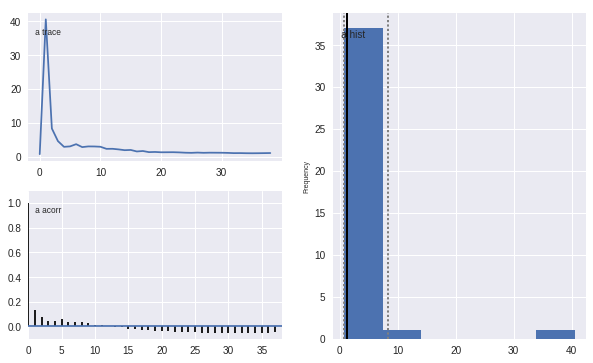

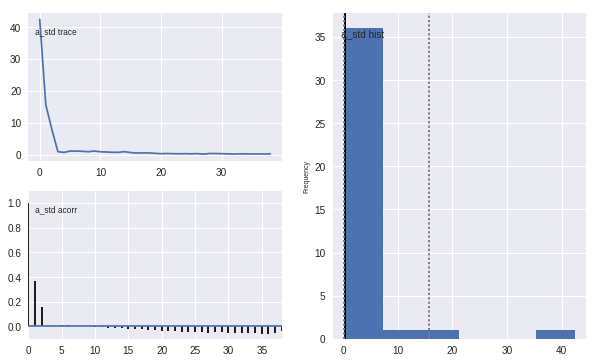

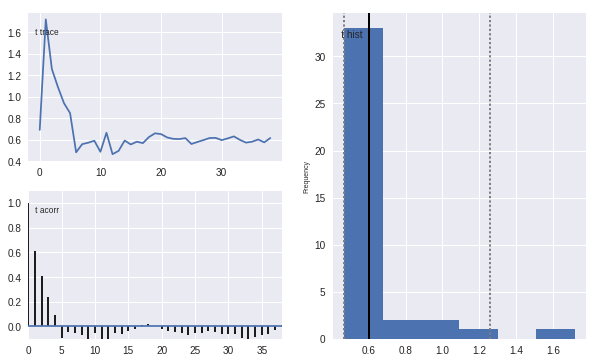

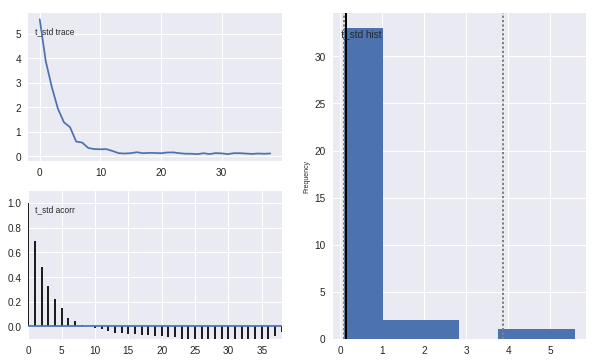

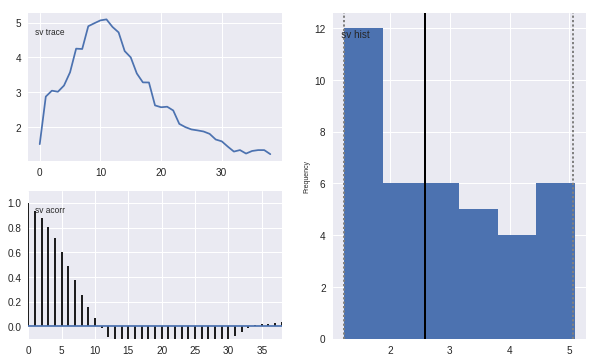

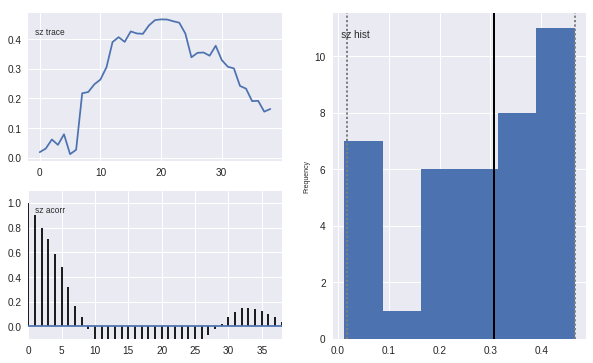

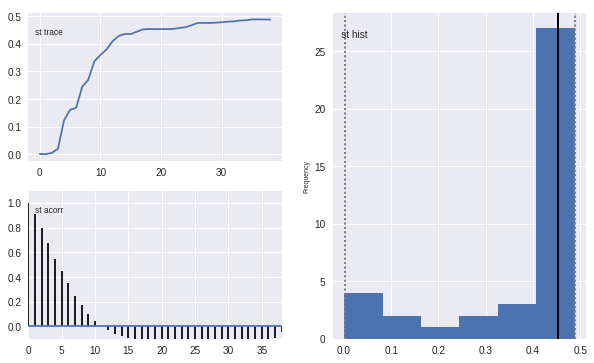

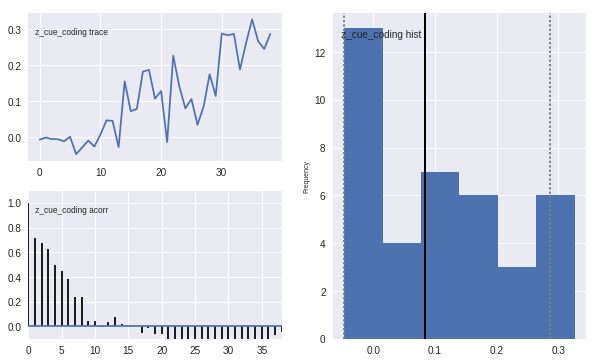

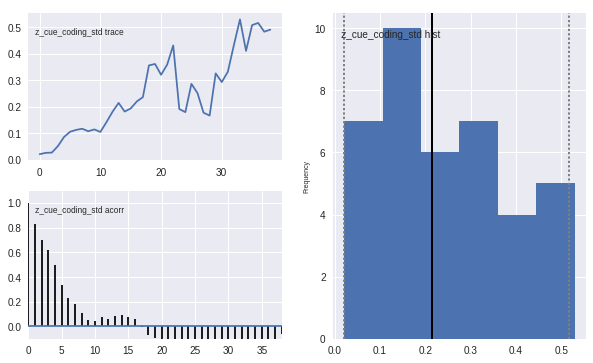

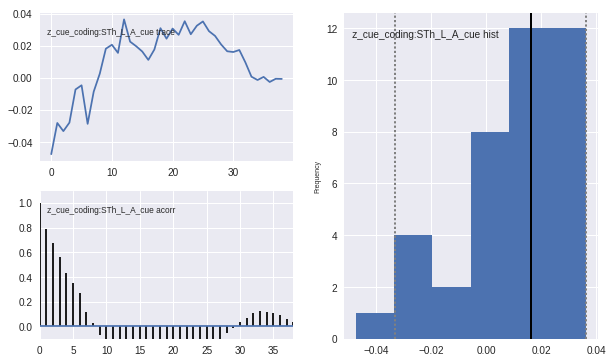

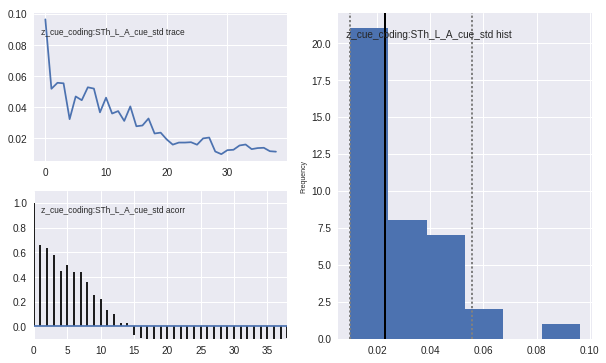

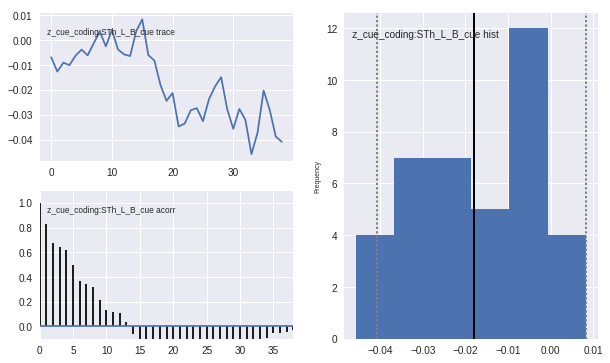

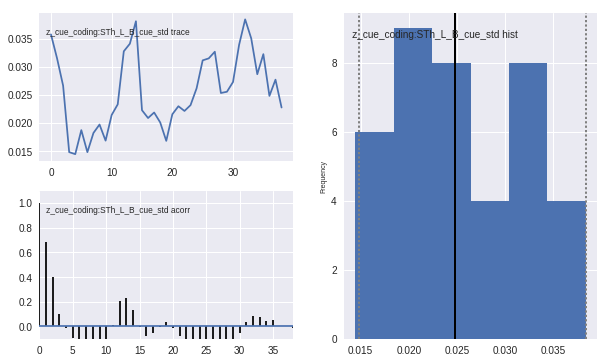

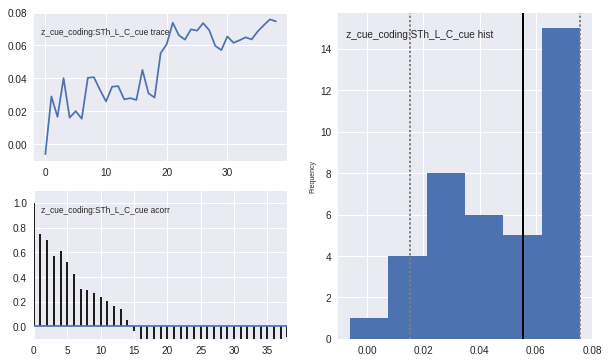

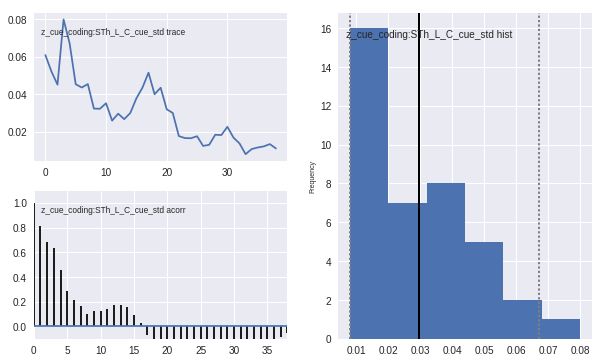

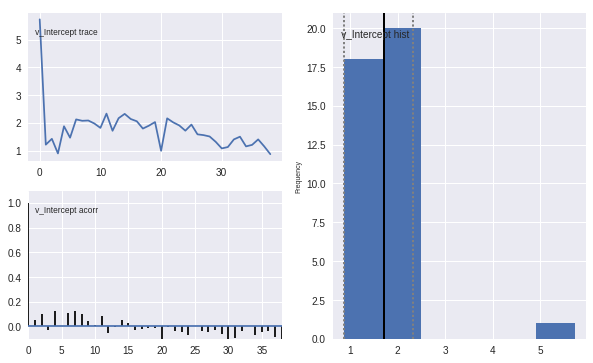

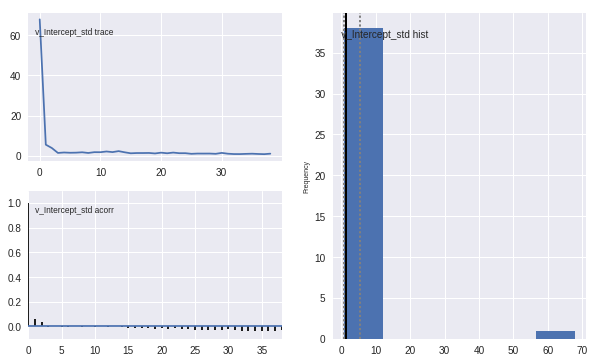

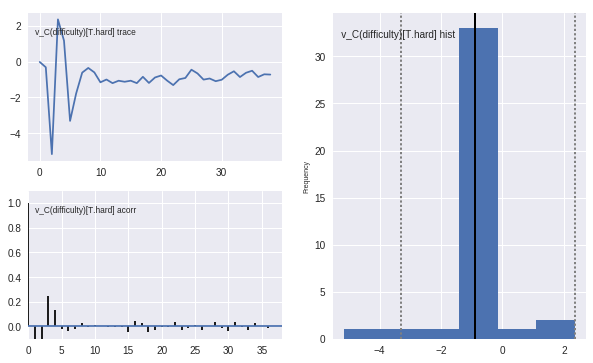

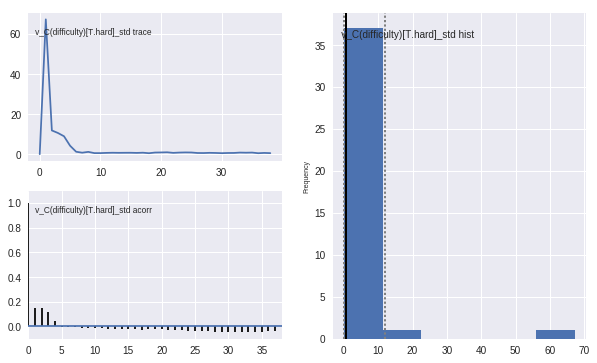

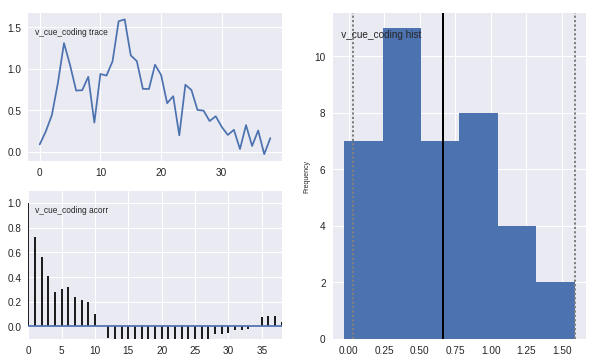

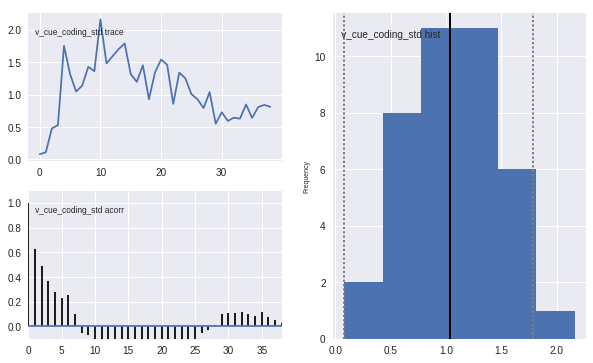

In [9]:
model.plot_posteriors()

In [68]:
hddm_model = get_model('start_point_super', 'L')

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [69]:
hddm_model.sample(100)

 [-------          21%                  ] 21 of 100 complete in 59.5 secHalting at iteration  20  of  100


In [66]:
hddm_model.sample(100)

 [-------          21%                  ] 21 of 100 complete in 46.9 secHalting at iteration  20  of  100


In [62]:
hddm_model = get_model('start_point_super', 'L')

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [63]:
hddm_model.sample(100)

 [-------          21%                  ] 21 of 100 complete in 55.0 secHalting at iteration  20  of  100


In [54]:
traces = hddm_model.get_traces()

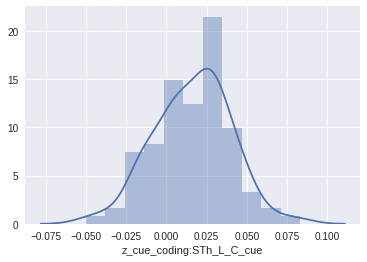

In [60]:
sns.distplot(traces['z_cue_coding:STh_L_C_cue'])

In [53]:
hddm_model.get_traces().columns.tolist()

['a',
 'a_std',
 'a_subj.1',
 'a_subj.10',
 'a_subj.11',
 'a_subj.12',
 'a_subj.13',
 'a_subj.14',
 'a_subj.15',
 'a_subj.16',
 'a_subj.17',
 'a_subj.18',
 'a_subj.19',
 'a_subj.2',
 'a_subj.3',
 'a_subj.4',
 'a_subj.5',
 'a_subj.6',
 'a_subj.7',
 'a_subj.8',
 'a_subj.9',
 'sv',
 't',
 't_std',
 't_subj.1',
 't_subj.10',
 't_subj.11',
 't_subj.12',
 't_subj.13',
 't_subj.14',
 't_subj.15',
 't_subj.16',
 't_subj.17',
 't_subj.18',
 't_subj.19',
 't_subj.2',
 't_subj.3',
 't_subj.4',
 't_subj.5',
 't_subj.6',
 't_subj.7',
 't_subj.8',
 't_subj.9',
 'v_C(difficulty)[T.hard]',
 'v_C(difficulty)[T.hard]:STh_L_A_stim',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_std',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_subj.1',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_subj.10',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_subj.11',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_subj.12',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_subj.13',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_subj.14',
 'v_C(difficulty)[T.hard]:STh_L_A_stim_s

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting z_cue_coding
Plotting z_cue_coding_std
Plotting z_cue_coding:STh_L_A_cue
Plotting z_cue_coding:STh_L_A_cue_std
Plotting z_cue_coding:STh_L_B_cue
Plotting z_cue_coding:STh_L_B_cue_std
Plotting z_cue_coding:STh_L_C_cue
Plotting z_cue_coding:STh_L_C_cue_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(difficulty)[T.hard]
Plotting v_C(difficulty)[T.hard]_std
Plotting v_STh_L_A_stim
Plotting v_STh_L_A_stim_std
Plotting v_C(difficulty)[T.hard]:STh_L_A_stim
Plotting v_C(difficulty)[T.hard]:STh_L_A_stim_std


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting v_STh_L_B_stim
Plotting v_STh_L_B_stim_std
Plotting v_C(difficulty)[T.hard]:STh_L_B_stim
Plotting v_C(difficulty)[T.hard]:STh_L_B_stim_std
Plotting v_STh_L_C_stim
Plotting v_STh_L_C_stim_std
Plotting v_C(difficulty)[T.hard]:STh_L_C_stim
Plotting v_C(difficulty)[T.hard]:STh_L_C_stim_std
Plotting v_cue_coding
Plotting v_cue_coding_std
Plotting v_cue_coding:STh_L_A_cue
Plotting v_cue_coding:STh_L_A_cue_std
Plotting v_cue_coding:STh_L_B_cue
Plotting v_cue_coding:STh_L_B_cue_std
Plotting v_cue_coding:STh_L_C_cue
Plotting v_cue_coding:STh_L_C_cue_std


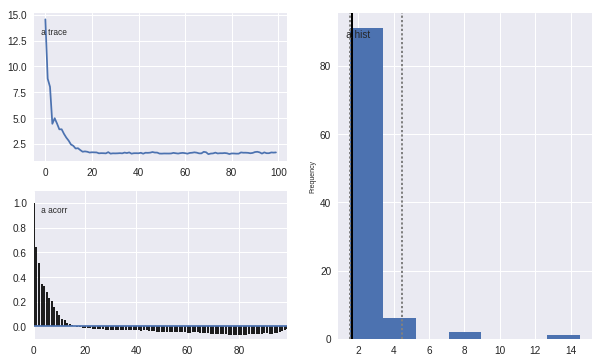

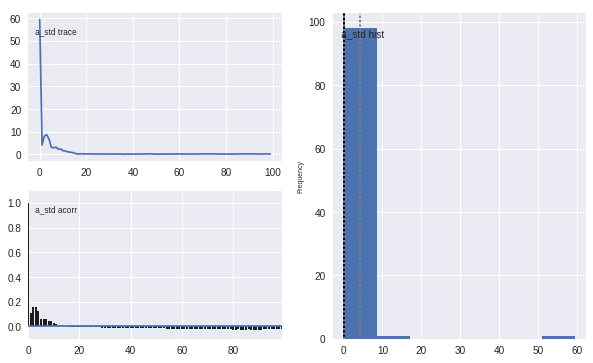

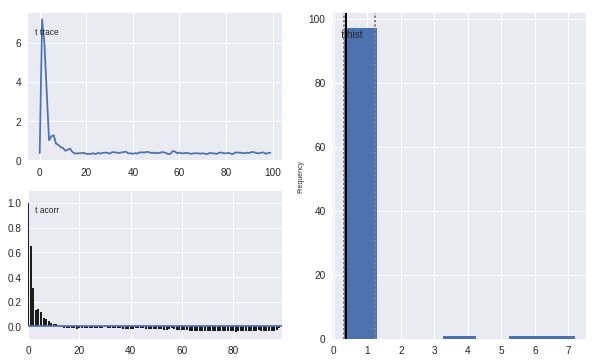

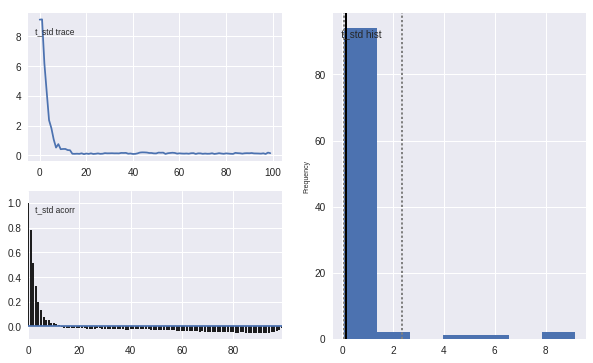

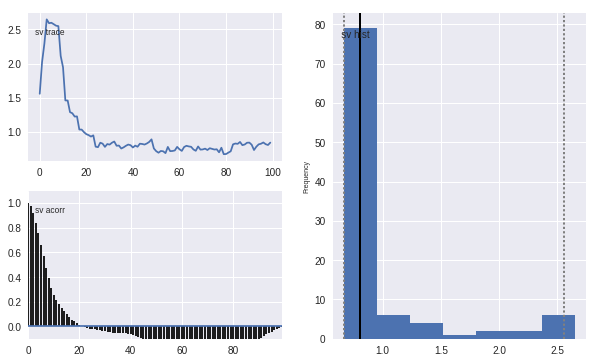

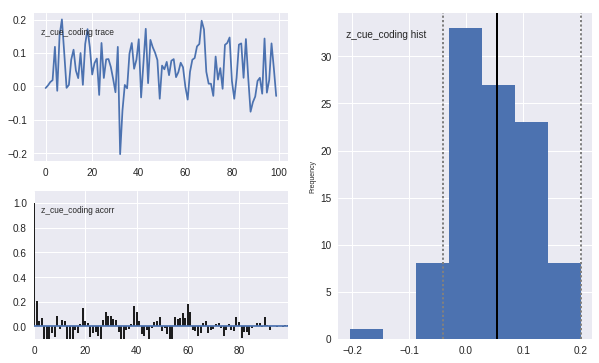

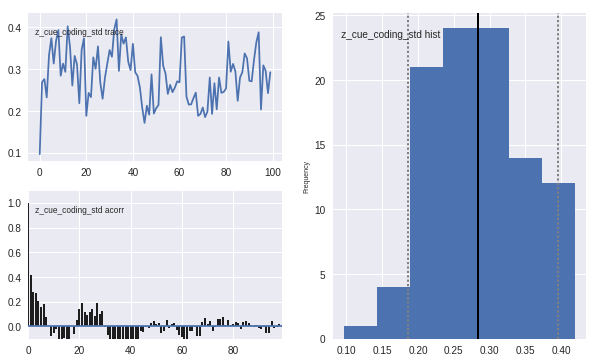

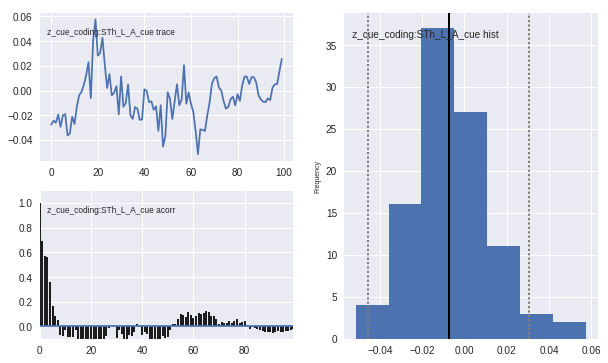

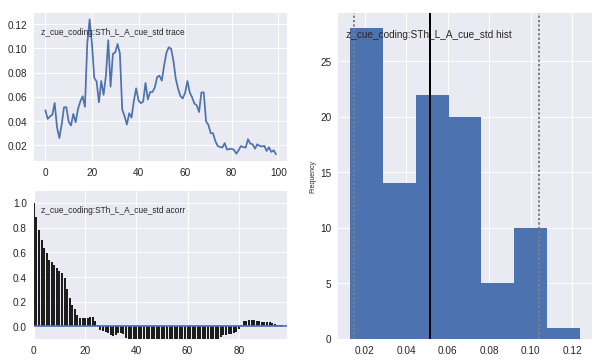

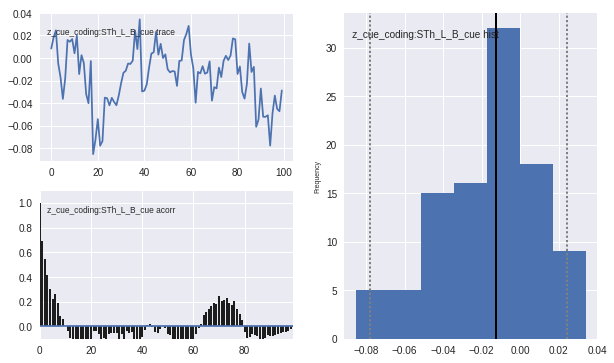

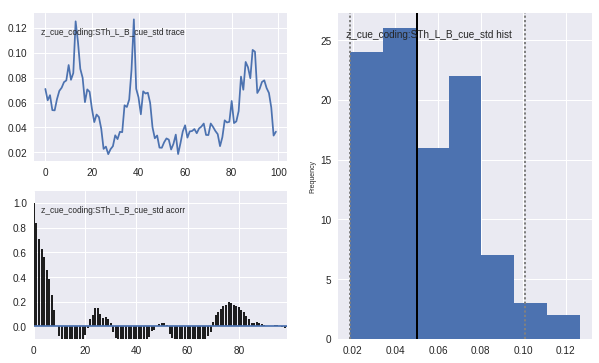

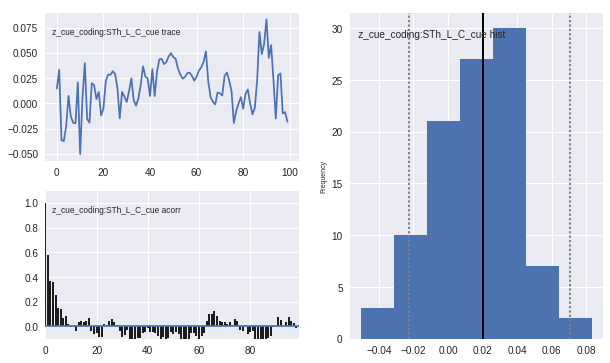

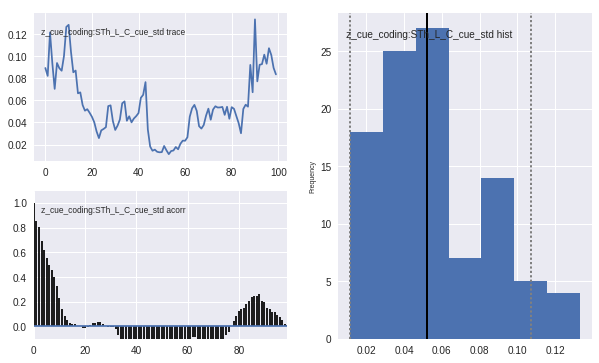

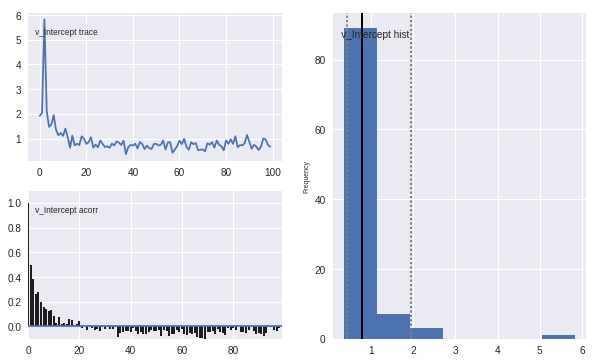

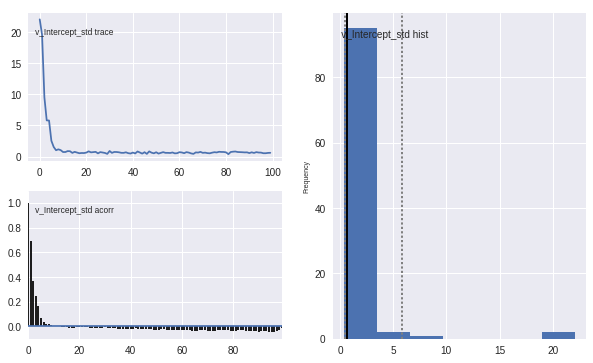

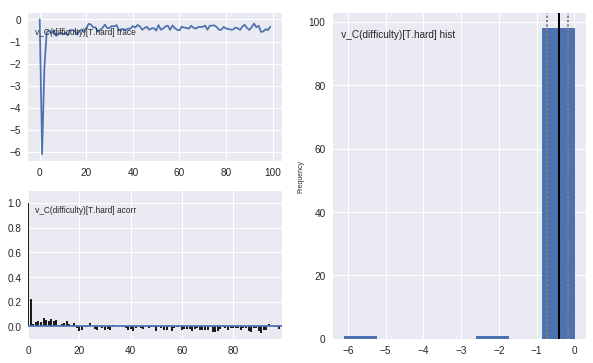

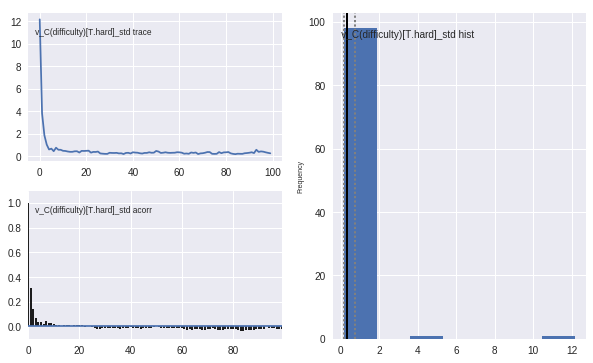

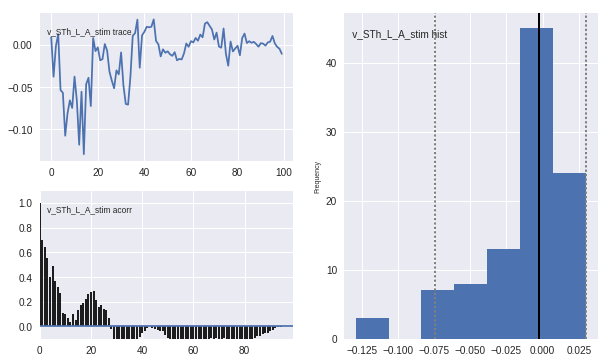

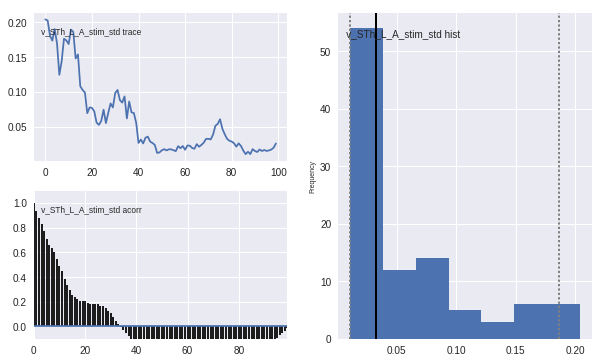

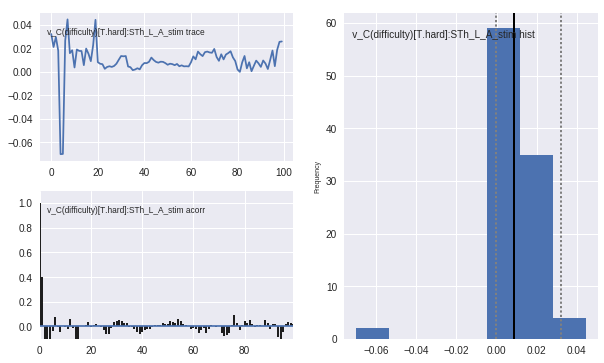

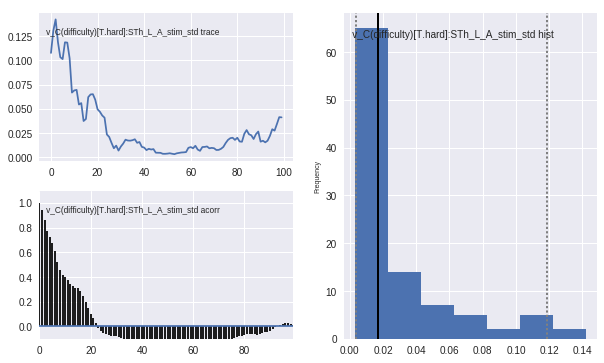

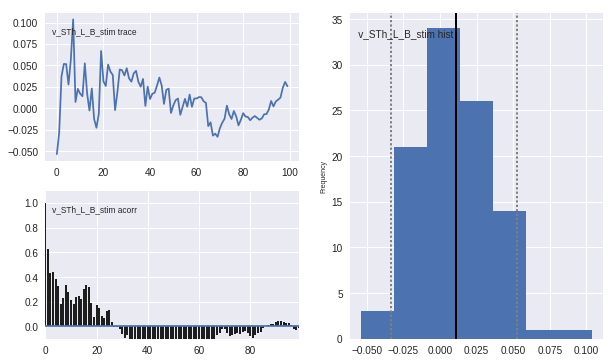

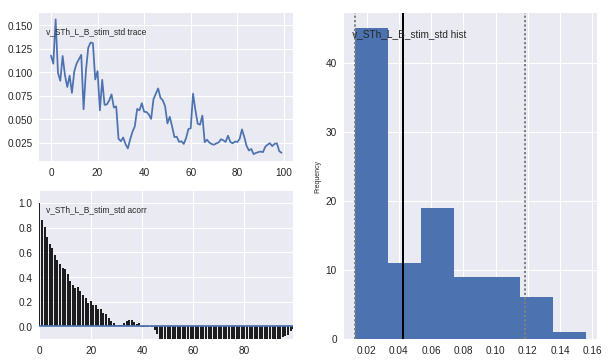

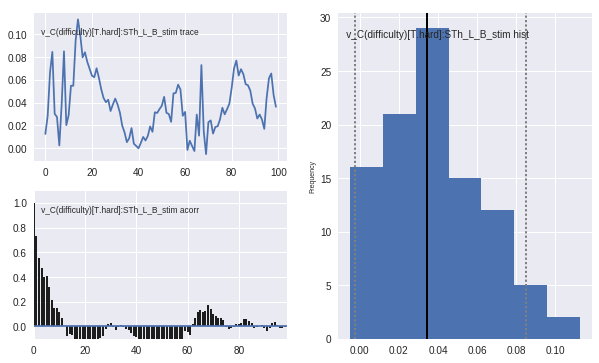

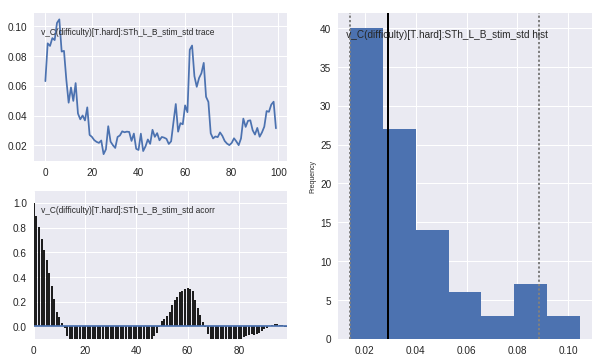

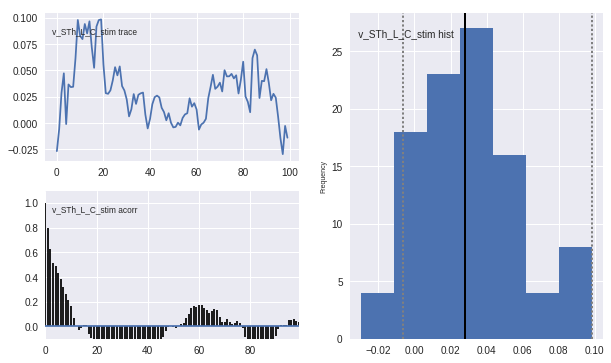

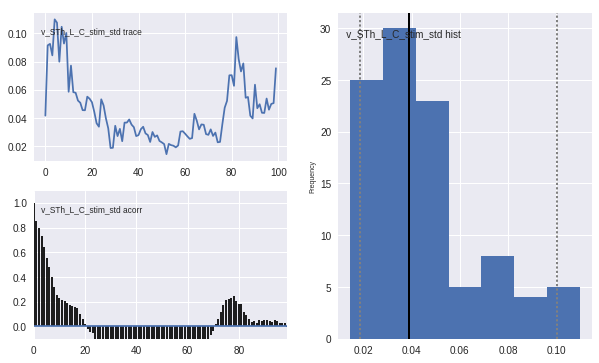

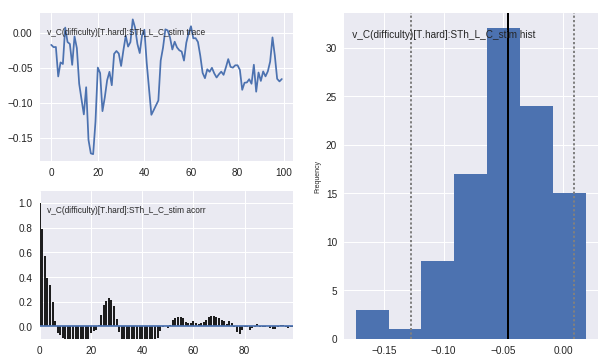

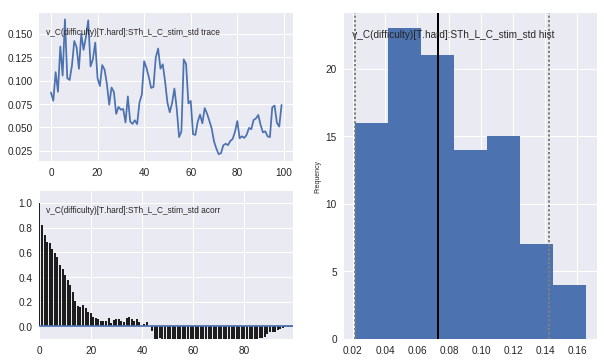

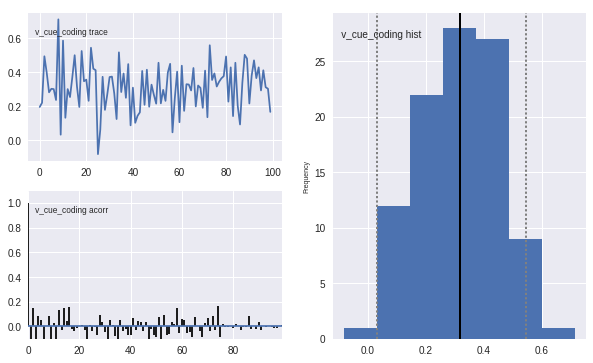

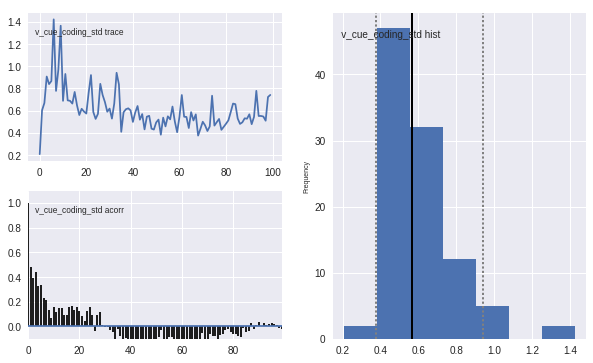

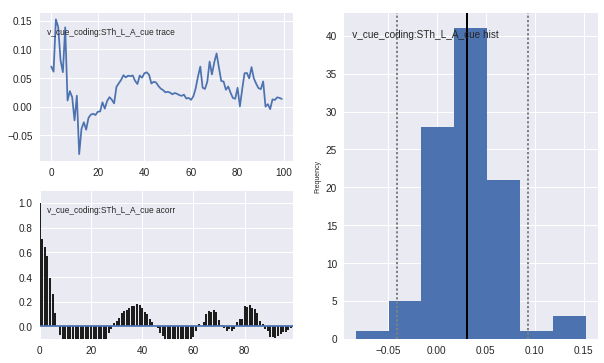

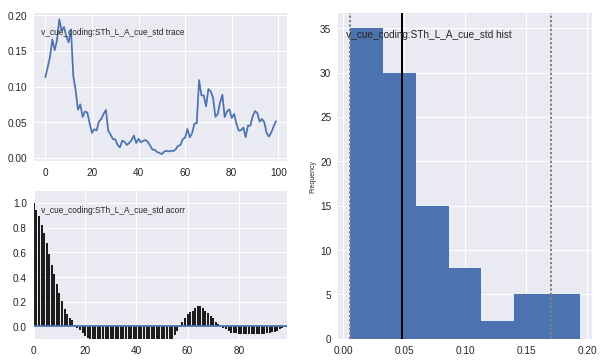

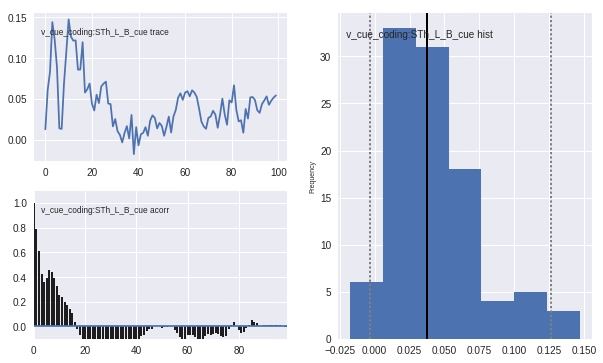

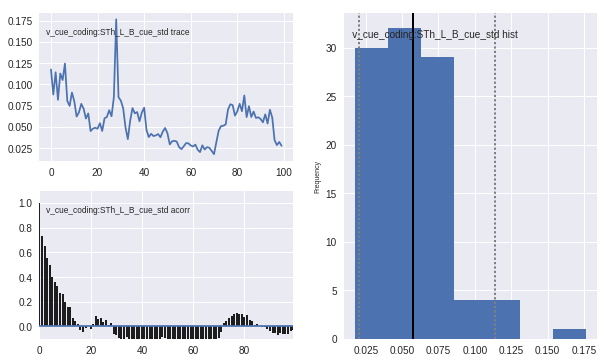

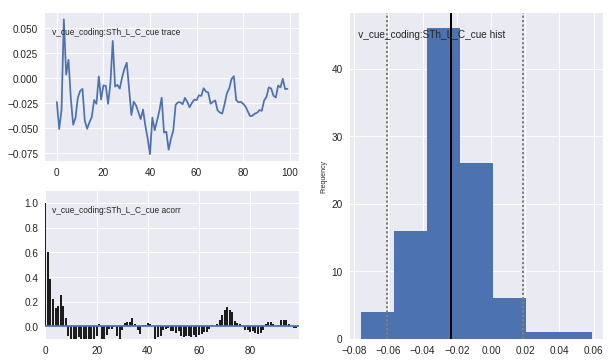

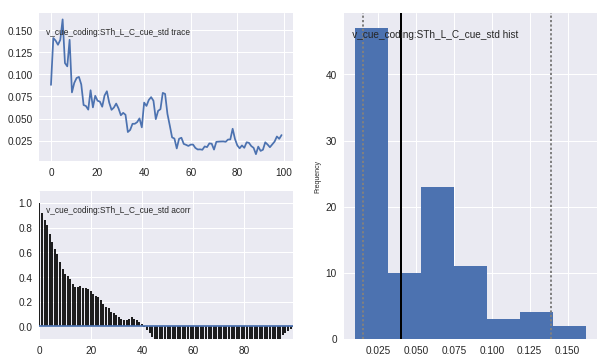

In [49]:
hddm_model.plot_posteriors()

In [ ]:
hemisphere = 'R'
model = 'all_super'

hddm_model = get_model(model, hemisphere)

reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

hddm_models = [hddm_model.load_db(fn, db='pickle') for fn in fns]

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_A_stim:correct', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_B_stim:correct', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_STh_R_C_stim:correct']


In [ ]:
traces = pandas.concat([m.get_traces() for m in hddm_models], ignore_index=True)

In [ ]:
sns.distplot(traces['z_cue_coding:STh_R_A_cue'])

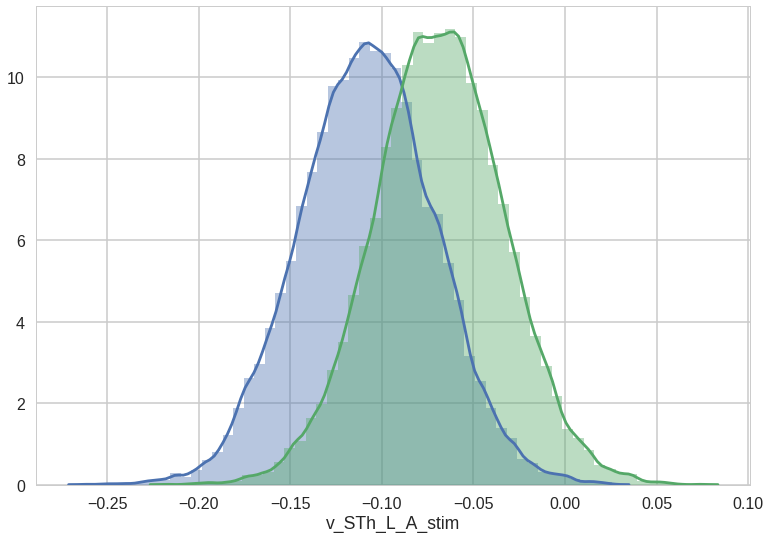

In [110]:
sns.distplot(traces['v_STh_L_A_stim'])
sns.distplot(traces['v_STh_L_A_stim'] + traces['v_C(difficulty)[T.hard]:STh_L_A_stim'])

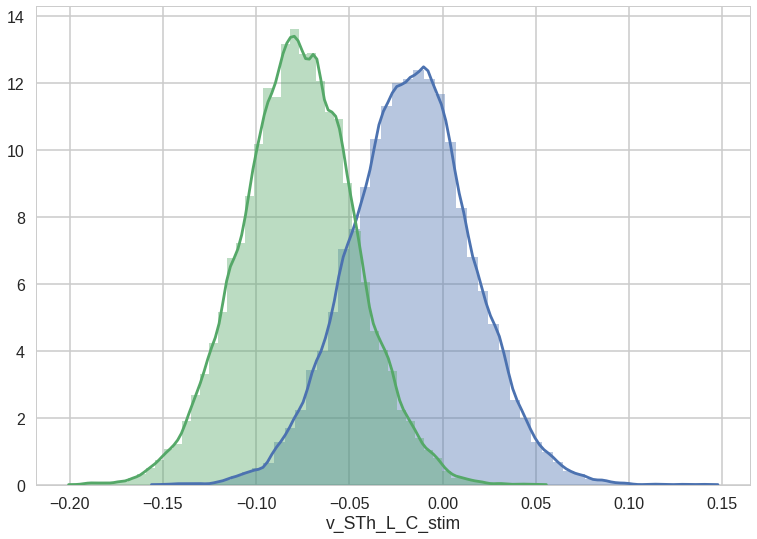

In [112]:
sns.distplot(traces['v_STh_L_C_stim'])
sns.distplot(traces['v_STh_L_C_stim'] + traces['v_C(difficulty)[T.hard]:STh_L_C_stim'])

In [105]:
(traces['v_STh_L_A_stim'] > 0).mean()

0.0023684210526315791

In [99]:
(traces['z_cue_coding:STh_L_C_cue'] > 0).mean()

0.23684210526315788

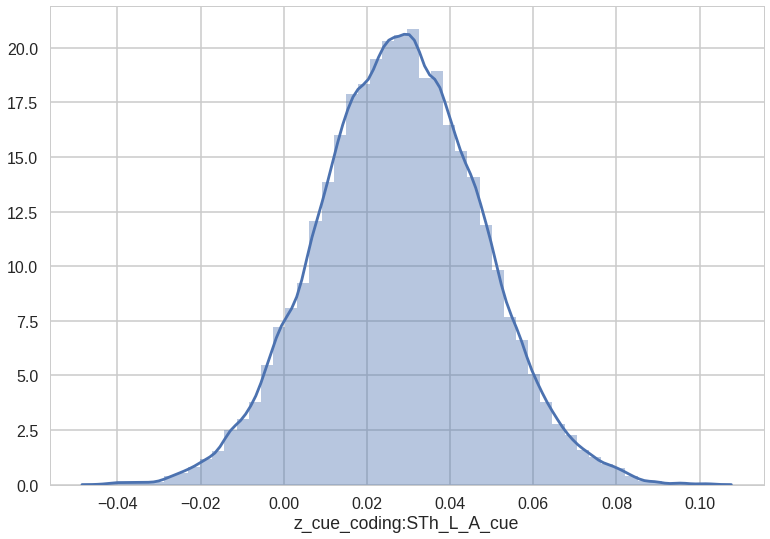

In [96]:
sns.distplot(traces['z_cue_coding:STh_L_A_cue'])

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting sv
Plotting z_cue_coding
Plotting z_cue_coding:STh_R_A_cue
Plotting z_cue_coding:STh_R_B_cue
Plotting z_cue_coding:STh_R_C_cue
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(difficulty)[T.hard]
Plotting v_STh_R_A_stim
Plotting v_C(difficulty)[T.hard]:STh_R_A_stim
Plotting v_STh_R_A_stim:correct
Plotting v_STh_R_B_stim
Plotting v_C(difficulty)[T.hard]:STh_R_B_stim
Plotting v_STh_R_B_stim:correct
Plotting v_STh_R_C_stim
Plotting v_C(difficulty)[T.hard]:STh_R_C_stim
Plotting v_STh_R_C_stim:correct


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


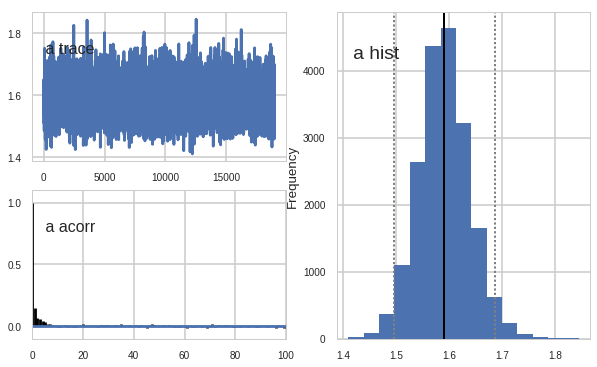

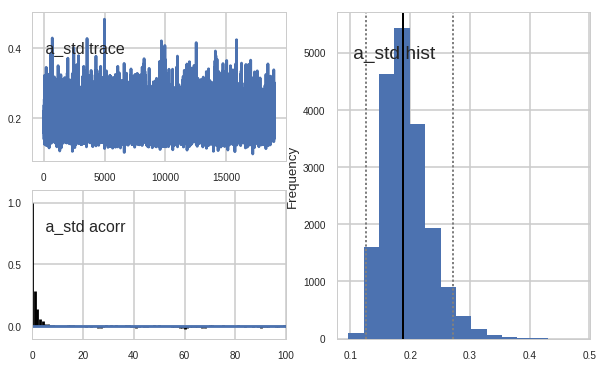

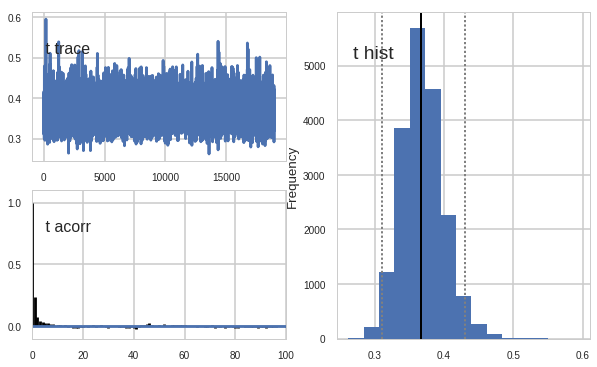

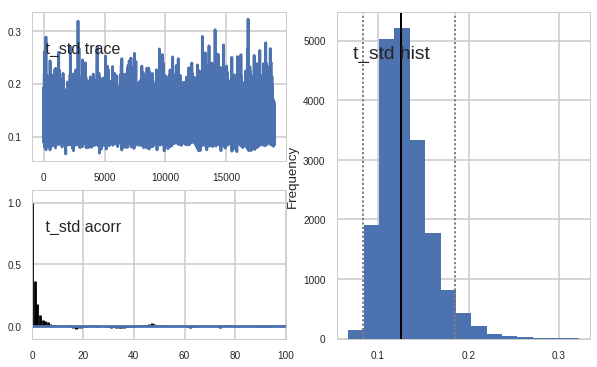

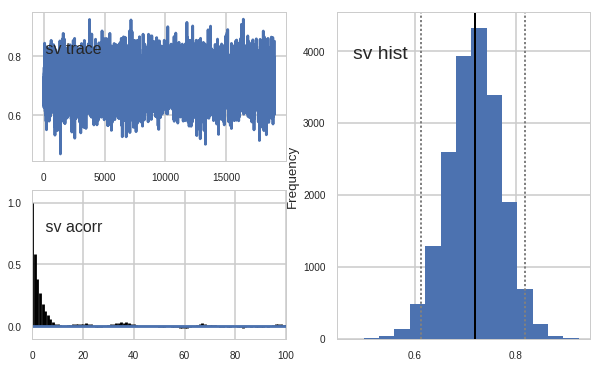

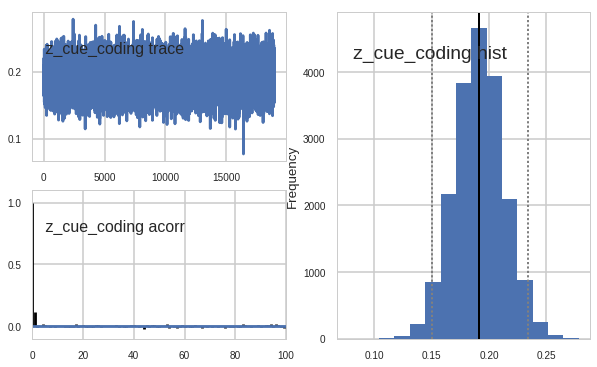

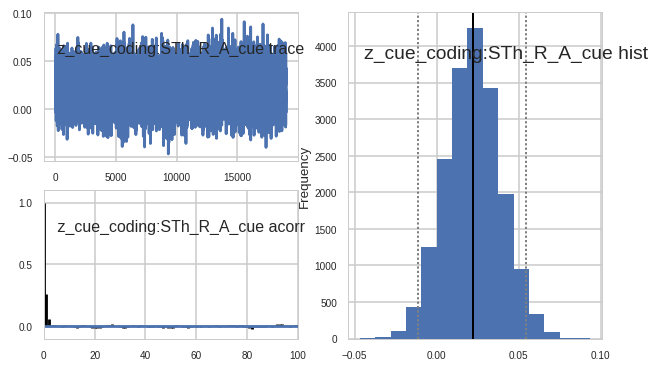

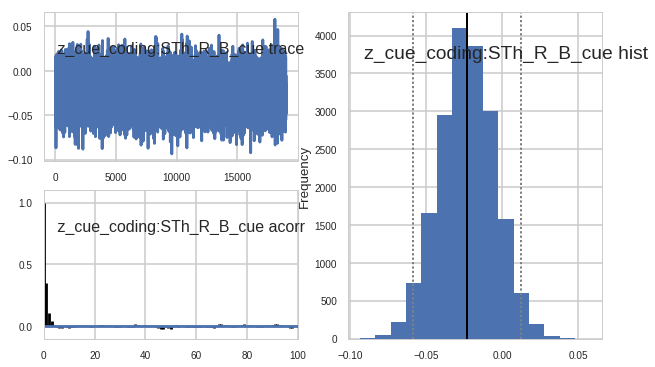

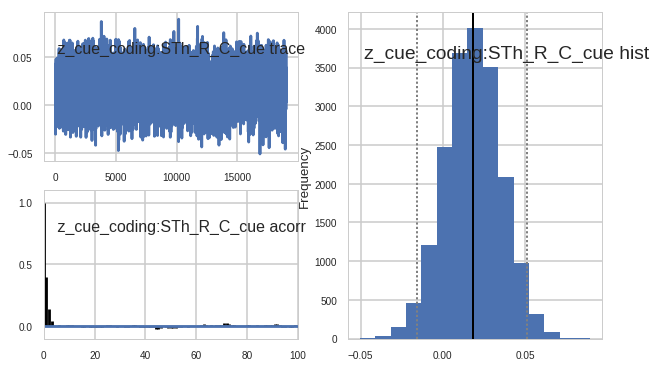

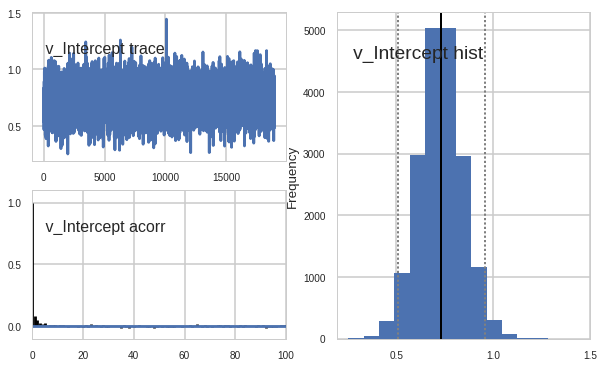

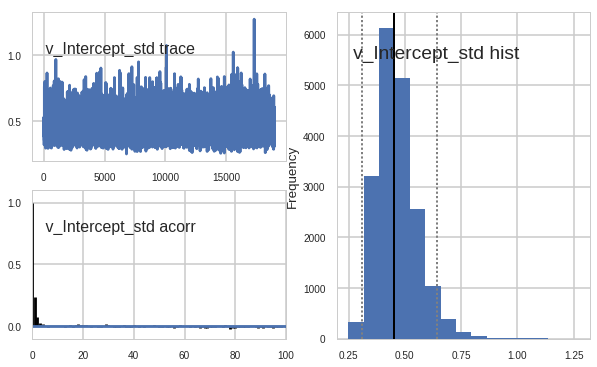

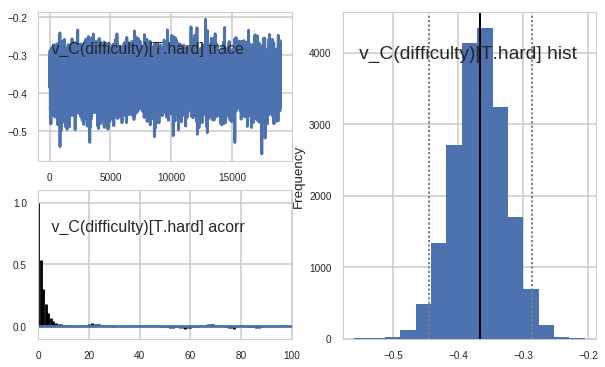

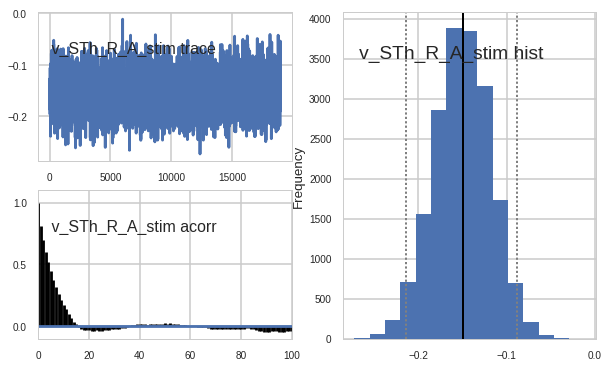

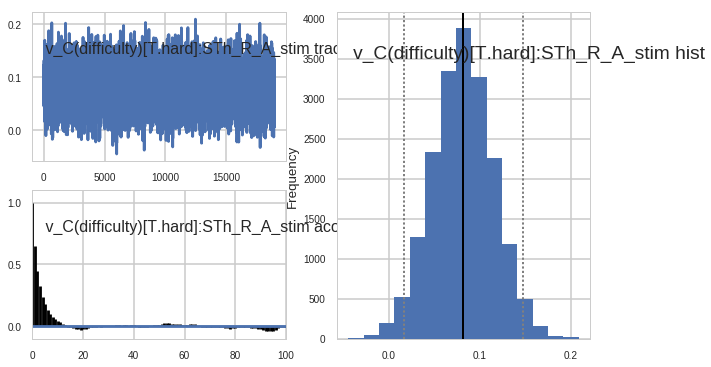

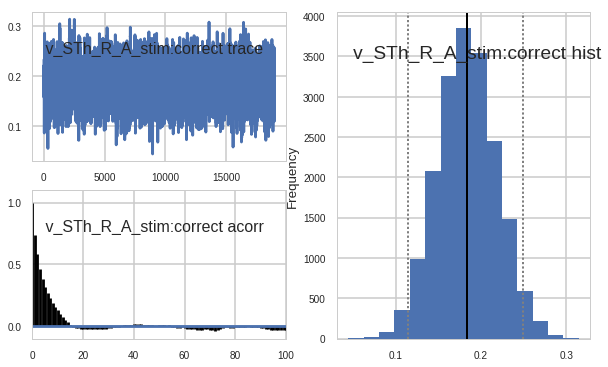

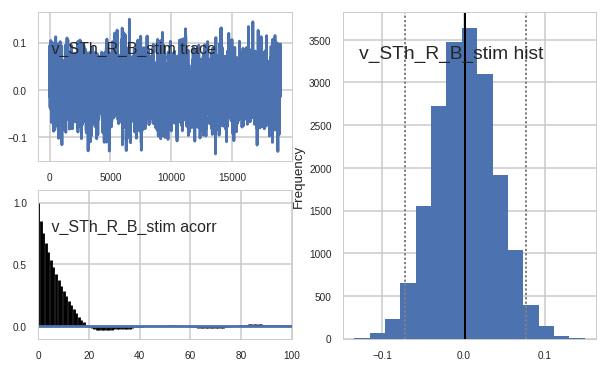

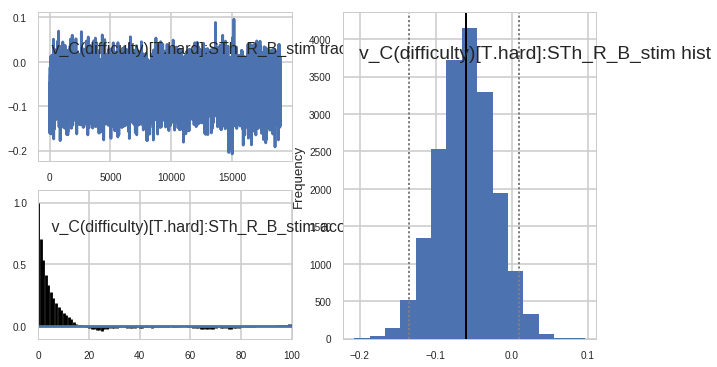

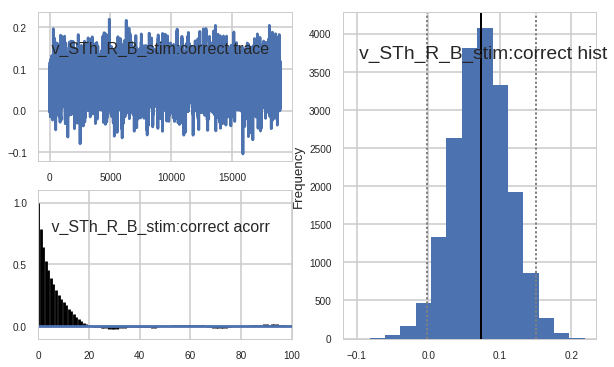

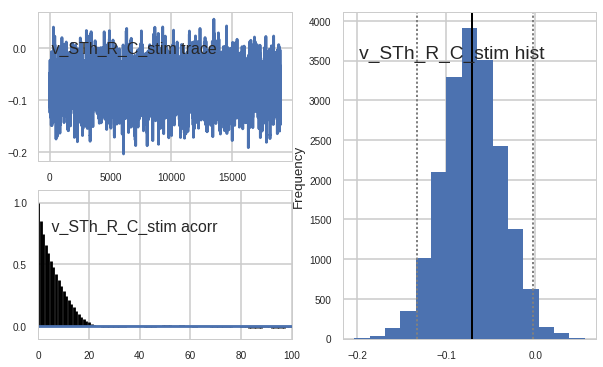

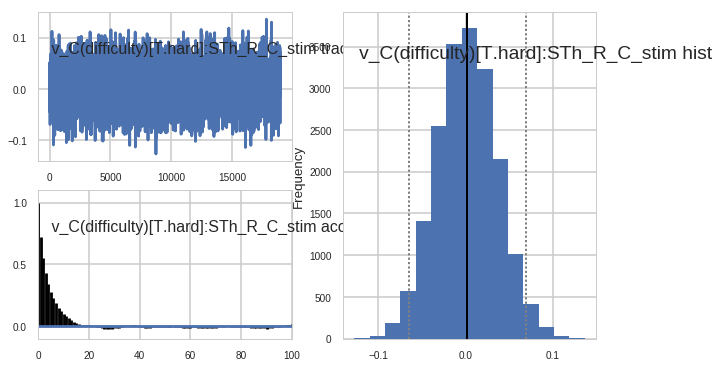

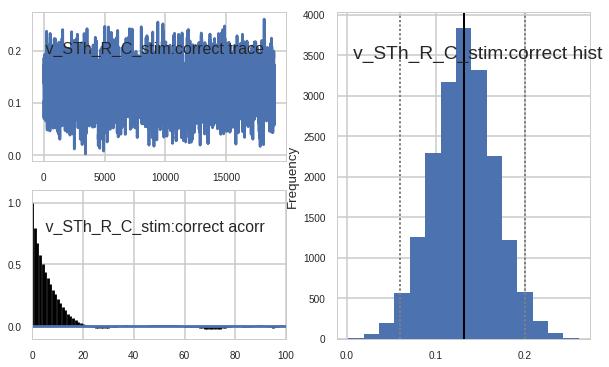

In [122]:
hddm_model.plot_posteriors()

# Drift super

In [3]:

def get_model(model, hemisphere):
    
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

    # Prepare data
    data = df
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    if model == 'drift_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim + C(difficulty)*{}_stim'.format('STh_{}_A'.format(hemisphere),
                                                                                                                 'STh_{}_B'.format(hemisphere),
                                                                                                                 'STh_{}_C'.format(hemisphere),),
                 'link_func': lambda x: x}

        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'drift_errors_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'start_point_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'all_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    return hddm_model

In [5]:
import pickle as pkl

In [16]:
hemisphere = 'L'
model = 'drift_super'

hddm_model = get_model(model, hemisphere)


reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

hddm_model.load_db(fns[0], db='pickle')

# hddm_models = [hddm_model.load_db(fn, db='pickle') for fn in fns]

for fn in fns[1:]:
    traces = pkl.load(open(fn))    
    for node in hddm_model.get_stochastics().node:
        node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim']


In [19]:
traces = hddm_model.get_traces()
traces.shape

(285000, 72)

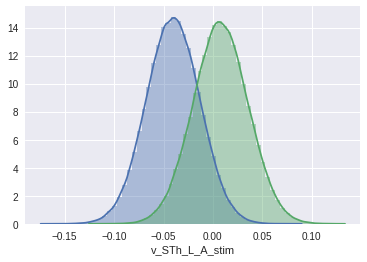

In [21]:
sns.distplot(traces['v_STh_L_A_stim'])
sns.distplot(traces['v_STh_L_A_stim'] + traces['v_C(difficulty)[T.hard]:STh_L_A_stim'])

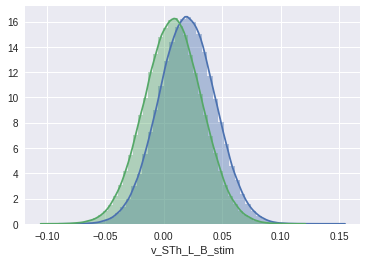

In [30]:
sns.distplot(traces['v_STh_L_B_stim'])
sns.distplot(traces['v_STh_L_B_stim'] + traces['v_C(difficulty)[T.hard]:STh_L_B_stim'])

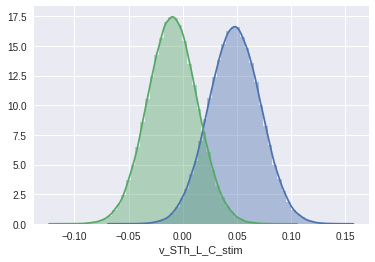

In [28]:
sns.distplot(traces['v_STh_L_C_stim'])
sns.distplot(traces['v_STh_L_C_stim'] + traces['v_C(difficulty)[T.hard]:STh_L_C_stim'])

In [26]:
(traces['v_STh_L_A_stim'] < 0).mean()

0.93298245614035091

In [25]:
(traces['v_STh_L_C_stim'] > 0).mean()

0.97792982456140354

AttributeError: 'bool' object has no attribute 'mean'

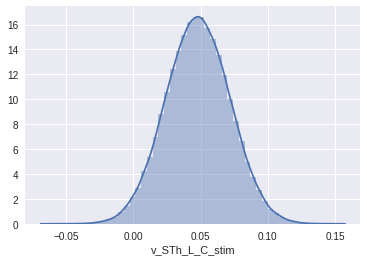

In [24]:
(sns.distplot(traces['v_STh_L_C_stim']) > 0).mean()

In [36]:
hemisphere = 'R'


model = 'start_point_super'

hddm_model = get_model(model, hemisphere)


reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

hddm_model.load_db(fns[0], db='pickle')

# hddm_models = [hddm_model.load_db(fn, db='pickle') for fn in fns]

for fn in fns[1:]:
    traces = pkl.load(open(fn))    
    for node in hddm_model.get_stochastics().node:
        node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']


In [37]:
traces = hddm_model.get_traces()

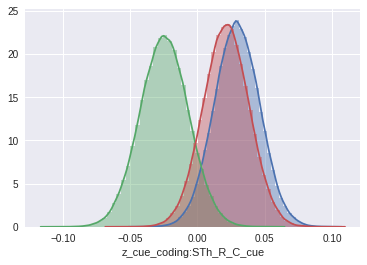

In [38]:
sns.distplot(traces['z_cue_coding:STh_R_A_cue'])
sns.distplot(traces['z_cue_coding:STh_R_B_cue'])
sns.distplot(traces['z_cue_coding:STh_R_C_cue'])
# sns.distplot(traces['v_STh_L_B_stim'] + traces['v_C(difficulty)[T.hard]:STh_L_B_stim'])